<a href="https://colab.research.google.com/github/pelegharel/robotics-final/blob/master/wall_trace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Only run on google collab

In [0]:
!rm -rf robotics-final
!git clone https://github.com/pelegharel/robotics-final.git

Cloning into 'robotics-final'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 9 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (9/9), done.


In [0]:
import numpy as np
from numpy.linalg import norm
from matplotlib import pyplot as plt
import cv2

In [0]:
def unit_vector(vector):
  return vector / norm(vector)

def unit_vectors(vectors):
    """ Returns the unit vector of the vector.  """
    return vectors / norm(vectors, axis=1).reshape(-1, 1)

def angles2vecs(robot_rotation, point_vectors):
    v1 = unit_vector(robot_rotation)
    v2s = unit_vectors(point_vectors)
    cosines = v2s @ v1.reshape(2, 1)
    sinuses = np.column_stack((-v2s[:,1], v2s[:,0])) @ v1.reshape(2, 1)
    return np.arctan2(sinuses, cosines)

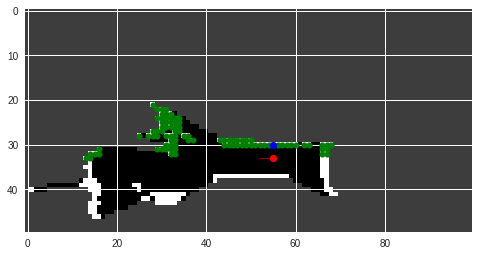

In [152]:
CAVANT = 254
UKNOWN = 205
OCCUPIED = 0

wm = cv2.imread("robotics-final/map.pgm")[150:200, 150:250, 1]
plt.imshow(wm)
robot_pos = (33, 55)
roll = np.pi
robot_rotation = (np.sin(roll), np.cos(roll))

occ_points = np.argwhere(wm == OCCUPIED)
vectors = occ_points - robot_pos
angles = angles2vecs(robot_rotation, vectors)

points_of_right = occ_points[np.where(angles > 0)[0]]

min_right_point = occ_points[np.argmin(norm(occ_points - robot_pos, axis=1))]


plt.scatter(points_of_right[:,1],
            points_of_right[:,0],
            row,
            color='green')

plt.scatter(*min_right_point[::-1], color='blue')  
plt.scatter(*robot_pos[::-1], color='red')
plt.arrow(robot_pos[1], robot_pos[0],
          3 * robot_rotation[1],
          3 * robot_rotation[0],
          color='red')